# Problem 2

In [2]:
# Setup:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import warnings

warnings.filterwarnings("ignore")

# Fix random seed for reproducibility
np.random.seed(42)

## Loading the Data for Problem 2

This code loads the data from `bv_data.csv` using the load_data helper function. Note that `data[:, 0]` is an array of all the $x$ values in the data and `data[:, 1]` is an array of the corresponding $y$ values.

In [7]:
def load_data(filename):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    Input:
        filename: given as a string.
    Output:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, skiprows=1, delimiter=",")

In [8]:
data = load_data("../data/bv_data.csv")
x = data[:, 0]
y = data[:, 1]

## Problem 2, Parts C-H

#### Algorithm (Learning Curves)

1. For each degree $d \in \{1,2,6,12\}$ and each training size $N$, take the first $N$ points.
2. Split those $N$ points into 5 contiguous folds.
3. For each fold, fit a degree-$d$ polynomial on the training folds and compute training and validation MSE.
4. Average the 5 fold errors to get the mean training and validation MSE for that $N$.
5. Repeat across all $N$ values to build the learning curves.

In [17]:
degrees = [1, 2, 6, 12]          # Polynomial degrees to evaluate
N_values = np.arange(20, 101, 5) # Training set sizes: 20, 25, ..., 100
num_folds = 5                    # 5-fold cross-validation

# We will store a list of training errors and validation errors for each degree.
learning_curves = {}

# Store polynomial coefficients for each degree and N (all folds).
fit_store = {degree: {} for degree in degrees}

for degree in degrees:
    # Initialize lists for this degree's learning curve
    train_errors = []
    val_errors = []

    # Loop over different training set sizes N
    for N in N_values:
        # Select only the first N points (as instructed)
        x_subset = x[:N]
        y_subset = y[:N]

        # Build a KFold splitter with contiguous blocks (no shuffle)
        kf = KFold(n_splits=num_folds)

        # Accumulators for fold errors and fitted coefficients
        fold_train_errors = []
        fold_val_errors = []
        fold_coeffs = []

        # Iterate through each fold
        for train_index, val_index in kf.split(x_subset):
            # Split the data into train/validation for this fold
            x_train, x_val = x_subset[train_index], x_subset[val_index]
            y_train, y_val = y_subset[train_index], y_subset[val_index]

            # Fit the polynomial model on the training data (degree d)
            coeffs = np.polyfit(x_train, y_train, degree)
            fold_coeffs.append(coeffs)

            # Evaluate the fitted polynomial on train and validation inputs
            y_train_pred = np.polyval(coeffs, x_train)
            y_val_pred = np.polyval(coeffs, x_val)

            # Compute MSE for train and validation and store them
            fold_train_errors.append(mean_squared_error(y_train, y_train_pred))
            fold_val_errors.append(mean_squared_error(y_val, y_val_pred))

        # Average the errors across folds for this N
        train_errors.append(np.mean(fold_train_errors))
        val_errors.append(np.mean(fold_val_errors))

        # Save fitted coefficients for this degree and N
        fit_store[degree][N] = fold_coeffs

    # Save this degree's learning curve results
    learning_curves[degree] = {
        "N": N_values,
        "train": np.array(train_errors),
        "val": np.array(val_errors)
    }

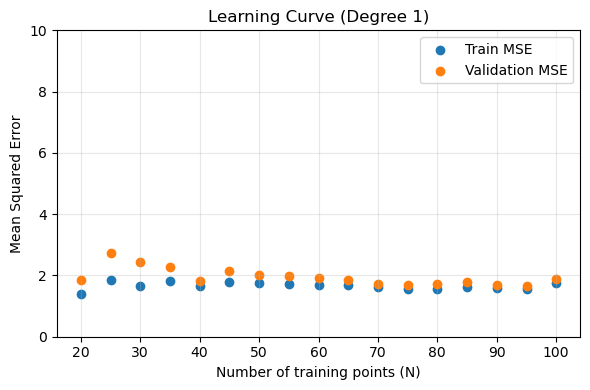

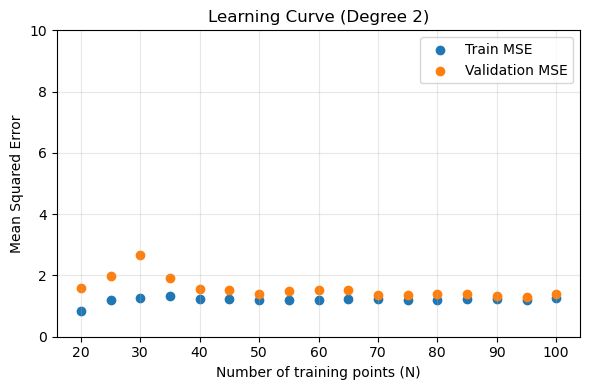

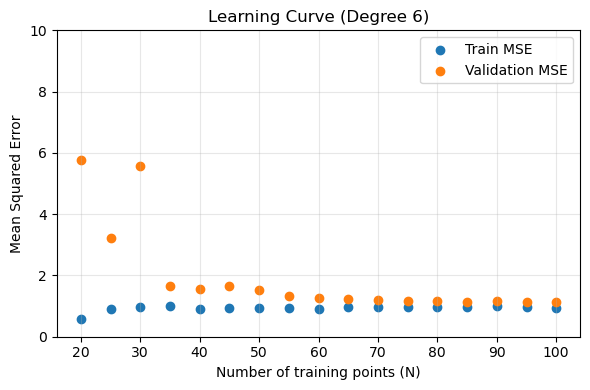

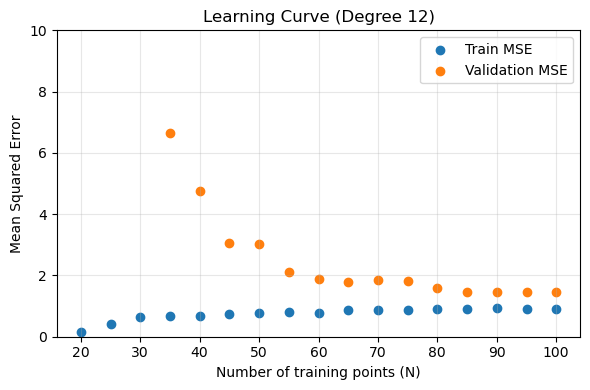

In [18]:
#Plot one learning curve per degree
for degree in degrees:
    plt.figure(figsize=(6, 4))
    plt.scatter(learning_curves[degree]["N"], learning_curves[degree]["train"], label="Train MSE")
    plt.scatter(learning_curves[degree]["N"], learning_curves[degree]["val"], label="Validation MSE")
    plt.xlabel("Number of training points (N)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Learning Curve (Degree {degree})")
    plt.ylim(0,10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Problem D

Q: Based on the learning curves, which polynomial regression model (i.e. which
degree polynomial) has the highest bias? How can you tell?

The highest bias is for the first model (1 degree) as it has the highest train MSE and it's consistent for all number of training points, in other words equally wrong for all data sets.

## Problem E

Q: Which model has the highest variance? How can you tell?

The degree-12 model shows the highest variance. It achieves very low training MSE but much higher validation MSE, especially for small $N$, and the gap between the two errors is much larger than for the lower-degree models.

## Problem F

Q: What does the learning curve of the quadratic model tell you about how much the
model will improve if we had additional training points?

The quadratic model’s learning curve flattens out, so adding more training points is unlikely to change the errors much. Both training and validation MSE plateau after the first part of the data.

## Problem G

Q: Why is training error generally lower than validation error?

The training error is generally lower because thats exactly what your model is supposed to bring down. The validation error only goes down once your model actually generalizes your data well.

## Problem H

Q: Based on the learning curves, which model would you expect to perform best on
some unseen data drawn from the same distribution as the training data, and why?

I would go with degree 2. Anything higher (6 or 12) looks like overfitting given how noisy the data are, and the curves start to behave poorly outside the range we actually observe. The quadratic fit captures the main trend without getting too wiggly, while a linear model clearly underfits.

### Extra plots to visualize the models performance and under- or overfitting

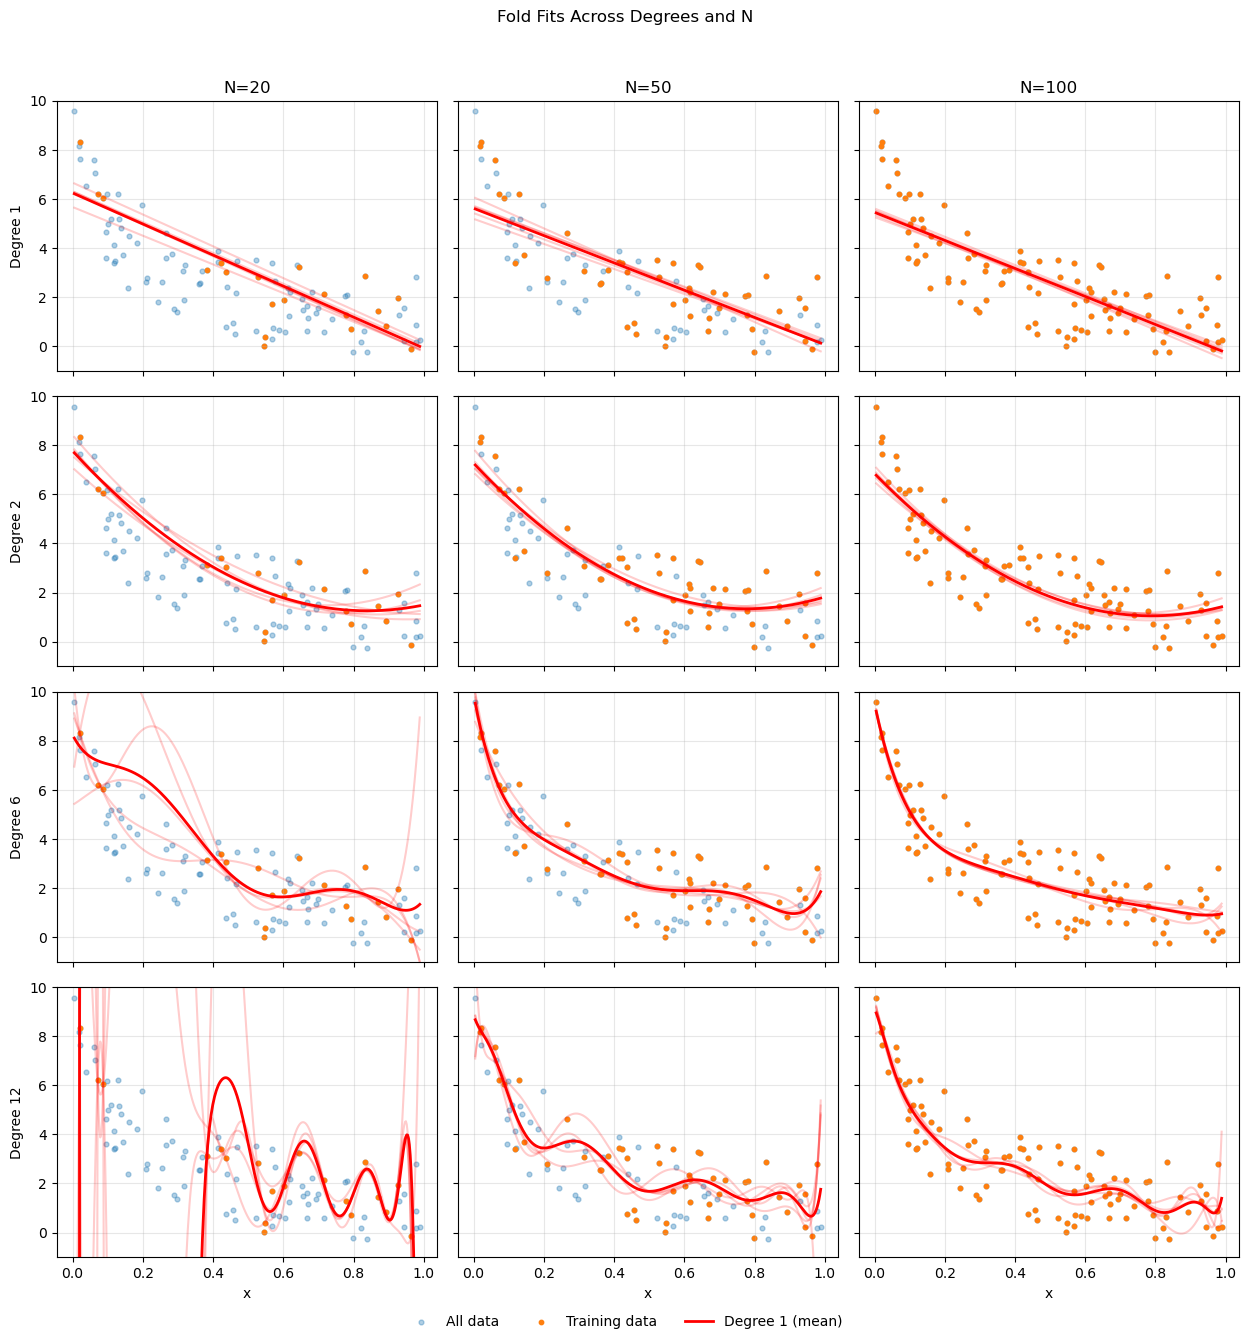

In [27]:
# Plot fold fits as subplots: rows = degrees, columns = N values
plot_N_values = [20, 50, 100]  # Choose N values to visualize
x_plot = np.linspace(x.min(), x.max(), 400)  # Smooth x-grid for curves

fig, axes = plt.subplots(
    nrows=len(degrees),
    ncols=len(plot_N_values),
    figsize=(4.2 * len(plot_N_values), 3.2 * len(degrees)),
    sharex=True,
    sharey=True
    )

for i, degree in enumerate(degrees):
    for j, plot_N in enumerate(plot_N_values):
        ax = axes[i, j]
        x_subset = x[:plot_N]
        y_subset = y[:plot_N]

        # Pull all saved fold fits for this degree and N
        fold_coeffs = fit_store[degree][plot_N]

        # Plot data and all fold fits for this degree
        ax.scatter(x, y, s=12, alpha=0.35, label="All data" if (i == 0 and j == 0) else None)
        ax.scatter(x_subset, y_subset, s=10, label=f"Training data" if i == 0 else None)

        # Plot each fold's fitted curve with low opacity
        y_folds = []
        for coeffs in fold_coeffs:
            y_curve = np.polyval(coeffs, x_plot)
            y_folds.append(y_curve)
            ax.plot(x_plot, y_curve, color="red", alpha=0.2)

        # Plot the average fitted curve across folds
        y_mean = np.mean(np.vstack(y_folds), axis=0)
        ax.plot(x_plot, y_mean, color="red", linewidth=2, label=f"Degree {degree} (mean)" if j == 0 else None)

        ax.set_ylim(-1, 10)

        if i == 0:
            ax.set_title(f"N={plot_N}")
        if j == 0:
            ax.set_ylabel(f"Degree {degree}")
        if i == len(degrees) - 1:
            ax.set_xlabel("x")
        ax.grid(True, alpha=0.3)

# Build a single legend for the whole figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Fold Fits Across Degrees and N", y=1.02)
fig.tight_layout()
plt.show()